In [1]:
import numpy as np
import tensorflow as tf
from random import randint
import scipy as scipy
import scipy.interpolate as interpolate
import math
from random import *
from sklearn.decomposition import PCA
from sklearn.datasets import load_diabetes
from scipy.stats import logistic
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from keras_radam.training import RAdamOptimizer

import tflib as lib
import tflib.save_images
import tflib.plot

#converters = {i:lambda s: float(s or -1000) for i in range(105)}

nasdaq = np.genfromtxt("./full/full_non_padding.csv", dtype='f', delimiter=',', skip_header=1, filling_values=0.0)
images = nasdaq
np.random.shuffle(images)
images = images[0:5000,:]
print(images.shape)

/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

(5000, 105)


In [2]:
# main parameters
Num_iter = 2000
N = 30000
max_grad_norm = 1000

BATCH_SIZE = 1000
BATCH_SIZE_2 = 1000
Lambda = 10.0
k=3

# additional parameters
gamma = 1.0
lr_decay = 0.3

dimensionality = images.shape[1]
number_of_points = images.shape[0]
number_of_neurons = number_of_points

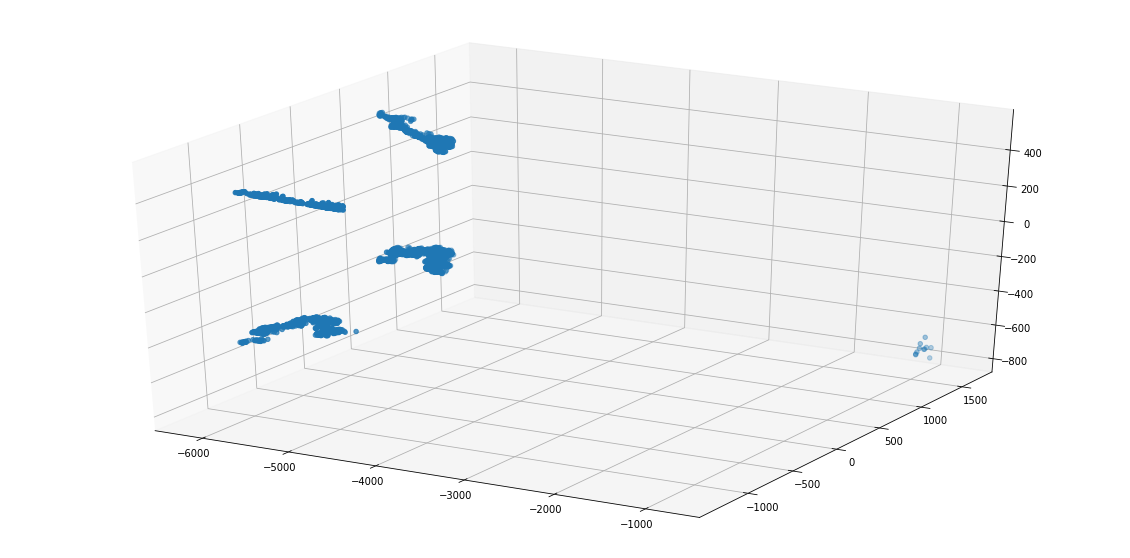

In [3]:
from mpl_toolkits.mplot3d import Axes3D

u, s, vh = np.linalg.svd(images, full_matrices=True)
D = vh[0:k]
P_svd = np.matmul(np.transpose(D), D)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
Data = np.matmul(images, np.transpose(D))
ax.scatter(Data[:,0], Data[:,1], Data[:,2])
plt.show()

Data = np.float32(np.transpose(images))

In [4]:
new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
Dataplace = tf.placeholder(tf.float32, shape=(dimensionality, None))

tf_data_x = gamma*tf.random_normal([BATCH_SIZE, dimensionality]) # аргументы функции
tf_data_y = tf.reduce_mean(tf.math.cos(tf.matmul(tf_data_x, Dataplace)), axis=1) # значения функции

tf_data_w = tf.placeholder(tf.float32, shape=(number_of_neurons,1))
tf_data_B = tf.placeholder(tf.float32, shape=(dimensionality,number_of_neurons))
tf_data_P = tf.placeholder(tf.float32, shape=(dimensionality, dimensionality))

tf_data_second = gamma*tf.random_normal([BATCH_SIZE_2, dimensionality])
Lbd = tf.placeholder(tf.float32, shape=[], name="lambda")

w = tf.Variable(tf.random_normal([number_of_neurons,1], stddev=0.0), name="neuron_weights")
B = tf.Variable(initial_value=Data, name="weights")

prediction = (2/number_of_neurons)*tf.matmul(tf.math.cos(tf.matmul(tf_data_x, B)), tf.nn.sigmoid(w))
#penalty = tf.square(tf.reduce_sum(tf.nn.sigmoid(w))-1.0)

out_loss = tf.reduce_mean(tf.square(prediction - tf_data_y))# + C*penalty

prediction2 = (2/number_of_neurons)*tf.matmul(tf.math.cos(tf.matmul(tf_data_second, B)), tf.nn.sigmoid(w))

grad_psi = tf.reshape(tf.gradients(prediction2, [tf_data_second])[0], [BATCH_SIZE_2, dimensionality])

new_part = grad_psi

tf_prediction2 = (2/number_of_neurons)*tf.matmul(tf.math.cos(tf.matmul(tf_data_second, tf_data_B)), tf.nn.sigmoid(tf_data_w))

tf_data_grad_psi = tf.reshape(tf.gradients(tf_prediction2, [tf_data_second])[0], [BATCH_SIZE_2, dimensionality])

old_part = tf.matmul(tf_data_grad_psi, tf_data_P)

loss = out_loss + Lbd*tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(new_part, old_part)), axis=1))

In [5]:
tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), max_grad_norm)
optimizer = RAdamOptimizer(learning_rate=new_lr, beta1=0.5, beta2=0.9) #tf.train.GradientDescentOptimizer(new_lr) tf.train.AdamOptimizer(learning_rate=new_lr, beta1=0.5, beta2=0.9) RMSPropOptimizer(new_lr) 
target = optimizer.apply_gradients(zip(grads, tvars), global_step=tf.contrib.framework.get_or_create_global_step())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.train.get_or_create_global_step


epoch = 1, train error = 30359.57519531
epoch = 1001, train error = 19198.51875000
epoch = 2001, train error = 11524.89380859
epoch = 3001, train error = 6371.38253418
epoch = 4001, train error = 3332.05332275
epoch = 5001, train error = 1661.14575195
epoch = 6001, train error = 811.63150513
epoch = 7001, train error = 385.21151001
epoch = 8001, train error = 178.76173187
epoch = 9001, train error = 82.77835327
epoch = 10001, train error = 38.12665134
epoch = 11001, train error = 17.35168700
epoch = 12001, train error = 7.86367015
epoch = 13001, train error = 3.56886894
epoch = 14001, train error = 1.60668110
epoch = 15001, train error = 0.72860473
epoch = 16001, train error = 0.32815738
epoch = 17001, train error = 0.14867587
epoch = 18001, train error = 0.06687729
epoch = 19001, train error = 0.03002657
epoch = 20001, train error = 0.01363912
epoch = 21001, train error = 0.00630516
epoch = 22001, train error = 0.00292538
epoch = 23001, train error = 0.00143812
epoch = 24001, train er

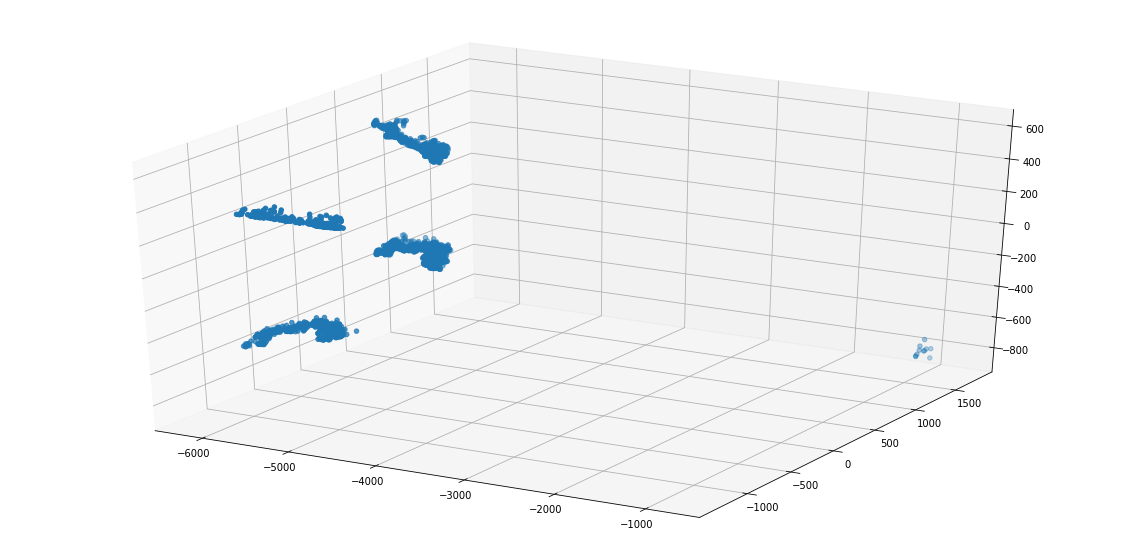

0.0006664074
2.3954606e-06
0.15867083
iter 0	Distance-till-svd	0.1586708277463913	Total-variance-to-retain %	0.0035945887211710215	Total-variance-to-retain	2.3954605694598285e-06
epoch = 1, train error = 0.00010094
epoch = 1001, train error = 0.00010197
epoch = 2001, train error = 0.00010129
epoch = 3001, train error = 0.00010150
epoch = 4001, train error = 0.00010065
epoch = 5001, train error = 0.00010124
epoch = 6001, train error = 0.00010100
epoch = 7001, train error = 0.00010145
epoch = 8001, train error = 0.00010081
epoch = 9001, train error = 0.00010103
epoch = 10001, train error = 0.00010124
epoch = 11001, train error = 0.00010197
epoch = 12001, train error = 0.00010103
epoch = 13001, train error = 0.00010096
epoch = 14001, train error = 0.00010139
[7.10720895e-04 9.19427566e-06 2.46249670e-06 7.13703855e-07
 3.39429846e-07 2.16933174e-07 1.83582813e-07 1.73569376e-07
 1.27730033e-07 9.79957022e-08 8.70075141e-08 7.70895241e-08
 6.49942464e-08 4.27494733e-08 2.85708328e-08 2.354

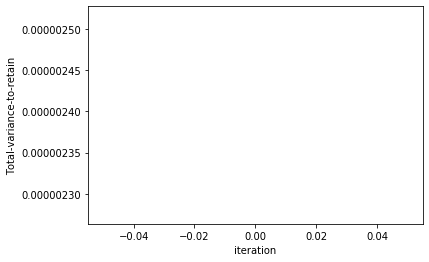

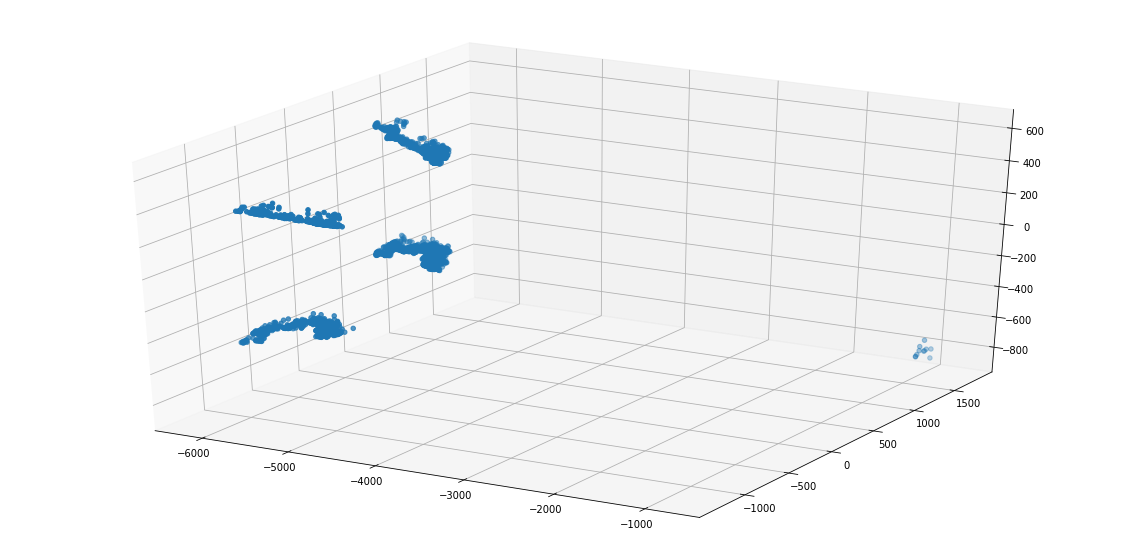

0.00072476343
2.385793e-06
0.14680822
iter 1	Distance-till-svd	0.1468082219362259	Total-variance-to-retain %	0.0032918232027441263	Total-variance-to-retain	2.385793095527333e-06
epoch = 1, train error = 0.00010191
epoch = 1001, train error = 0.00010070
epoch = 2001, train error = 0.00010198
epoch = 3001, train error = 0.00010182
epoch = 4001, train error = 0.00010096
epoch = 5001, train error = 0.00010129
epoch = 6001, train error = 0.00010217
epoch = 7001, train error = 0.00010184
epoch = 8001, train error = 0.00010177
epoch = 9001, train error = 0.00010112
epoch = 10001, train error = 0.00010184
epoch = 11001, train error = 0.00010051
epoch = 12001, train error = 0.00010158
epoch = 13001, train error = 0.00010122
epoch = 14001, train error = 0.00010123
epoch = 15001, train error = 0.00010099
epoch = 16001, train error = 0.00010093
epoch = 17001, train error = 0.00010150
[6.53153926e-04 9.50273352e-06 2.43285126e-06 6.30764248e-07
 3.57606524e-07 2.23598477e-07 1.91927271e-07 1.833888

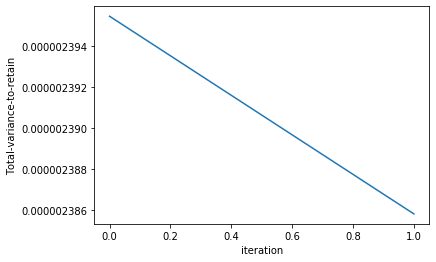

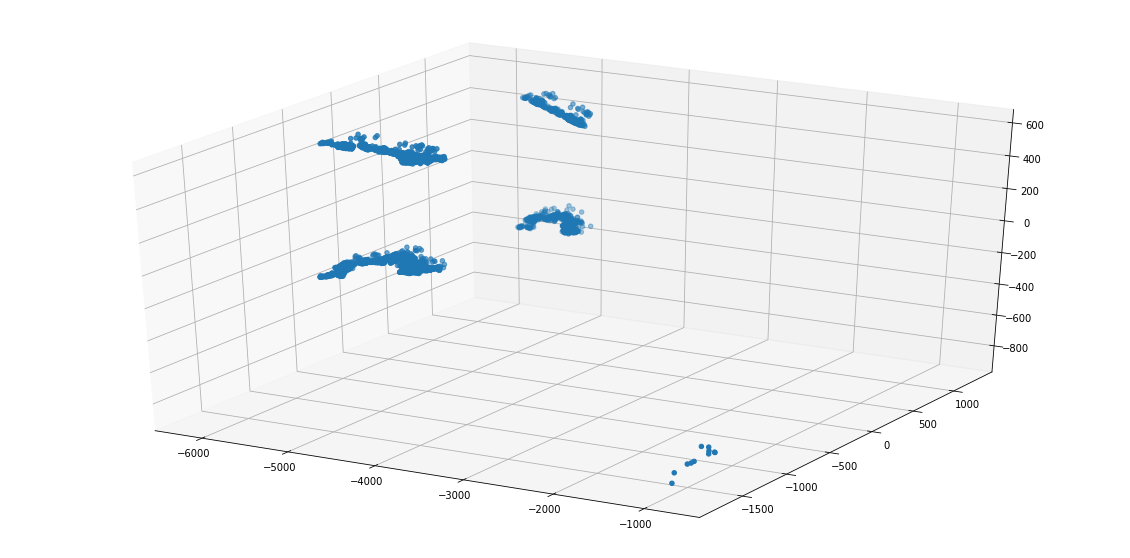

0.00066743407
2.3446128e-06
0.1349325
iter 2	Distance-till-svd	0.1349325031042099	Total-variance-to-retain %	0.003512875409796834	Total-variance-to-retain	2.344612767046783e-06
epoch = 1, train error = 0.00010186
epoch = 1001, train error = 0.00010101
epoch = 2001, train error = 0.00010160
epoch = 3001, train error = 0.00010182
epoch = 4001, train error = 0.00010097
epoch = 5001, train error = 0.00010114
epoch = 6001, train error = 0.00010161
epoch = 7001, train error = 0.00010172
epoch = 8001, train error = 0.00010106
epoch = 9001, train error = 0.00010086
epoch = 10001, train error = 0.00010177
epoch = 11001, train error = 0.00010182
[6.17789454e-04 9.46828641e-06 2.53566554e-06 6.86573856e-07
 3.39366835e-07 2.02153998e-07 1.89353727e-07 1.61204312e-07
 1.12558247e-07 1.00812052e-07 8.21838384e-08 7.79894265e-08
 6.70053595e-08 4.04365608e-08 2.81461556e-08 2.37658675e-08
 1.87360936e-08 1.59899951e-08 1.47951162e-08 1.31073392e-08
 1.29550850e-08 1.10035803e-08 1.04951692e-08 1.007

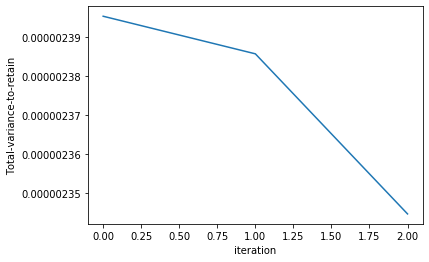

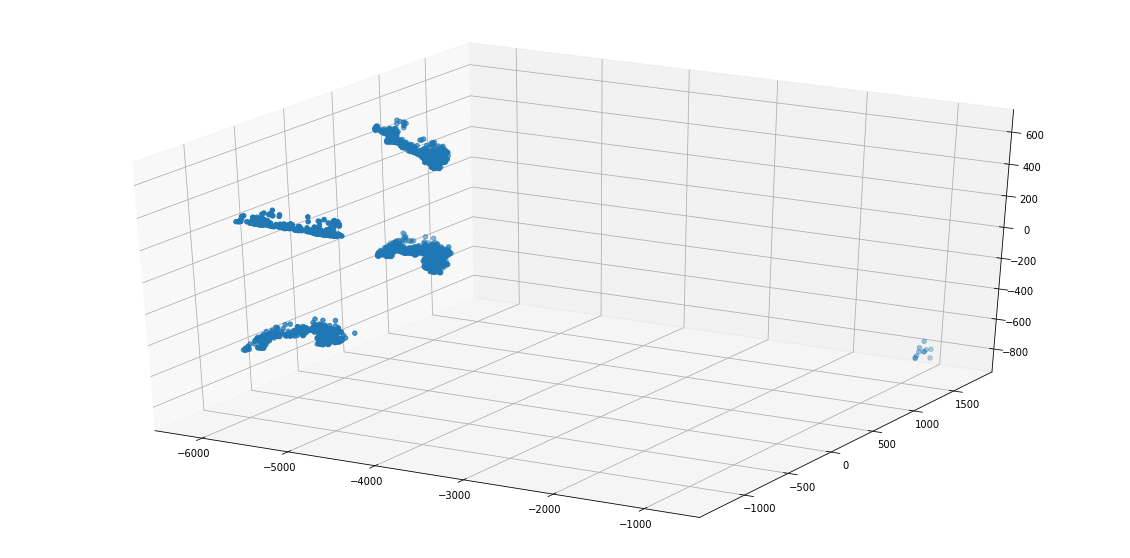

0.0006321201
2.3267223e-06
0.17328686
iter 3	Distance-till-svd	0.17328685522079468	Total-variance-to-retain %	0.0036808231379836798	Total-variance-to-retain	2.3267223241418833e-06
epoch = 1, train error = 0.00010206
epoch = 1001, train error = 0.00010143
epoch = 2001, train error = 0.00010125
epoch = 3001, train error = 0.00010097
epoch = 4001, train error = 0.00010105
epoch = 5001, train error = 0.00010219
epoch = 6001, train error = 0.00010147
epoch = 7001, train error = 0.00010124
epoch = 8001, train error = 0.00010072
epoch = 9001, train error = 0.00010074
epoch = 10001, train error = 0.00010212
epoch = 11001, train error = 0.00010102
epoch = 12001, train error = 0.00010084
epoch = 13001, train error = 0.00010126
epoch = 14001, train error = 0.00010141
epoch = 15001, train error = 0.00010273
[6.34659664e-04 9.45048487e-06 2.27462124e-06 6.28599480e-07
 3.45531731e-07 2.22253661e-07 1.86453363e-07 1.73346251e-07
 1.25899177e-07 1.00748032e-07 9.32399189e-08 7.49923927e-08
 5.9204850

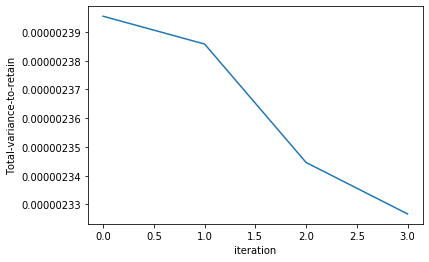

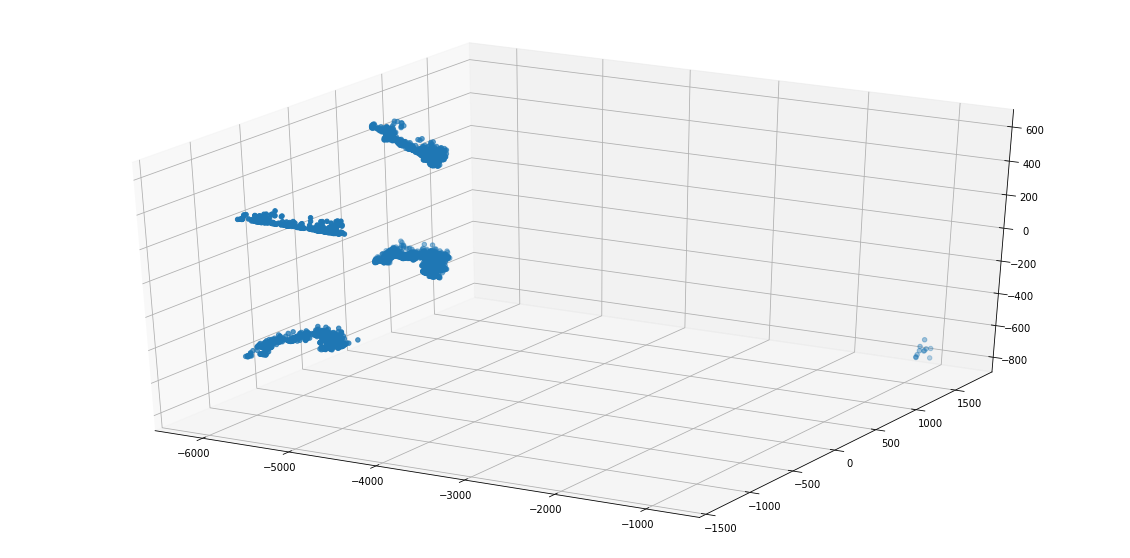

0.00064870075
2.3159228e-06
0.12785026
iter 4	Distance-till-svd	0.1278502643108368	Total-variance-to-retain %	0.0035700942389667034	Total-variance-to-retain	2.315922756679356e-06
epoch = 1, train error = 0.00010105
epoch = 1001, train error = 0.00010262
epoch = 2001, train error = 0.00010148
epoch = 3001, train error = 0.00010153
epoch = 4001, train error = 0.00010182
epoch = 5001, train error = 0.00010145
epoch = 6001, train error = 0.00010212
epoch = 7001, train error = 0.00010103
epoch = 8001, train error = 0.00010104
epoch = 9001, train error = 0.00010122
epoch = 10001, train error = 0.00010119
epoch = 11001, train error = 0.00010122
epoch = 12001, train error = 0.00010103
epoch = 13001, train error = 0.00010068
epoch = 14001, train error = 0.00010172
[6.86921645e-04 9.16037607e-06 2.43896125e-06 6.36409254e-07
 3.53494869e-07 2.27117539e-07 1.84384660e-07 1.68924529e-07
 1.23636724e-07 1.12397103e-07 8.21891675e-08 7.67036070e-08
 6.49346958e-08 4.22423199e-08 2.68548952e-08 2.531

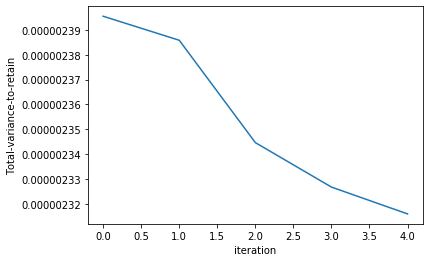

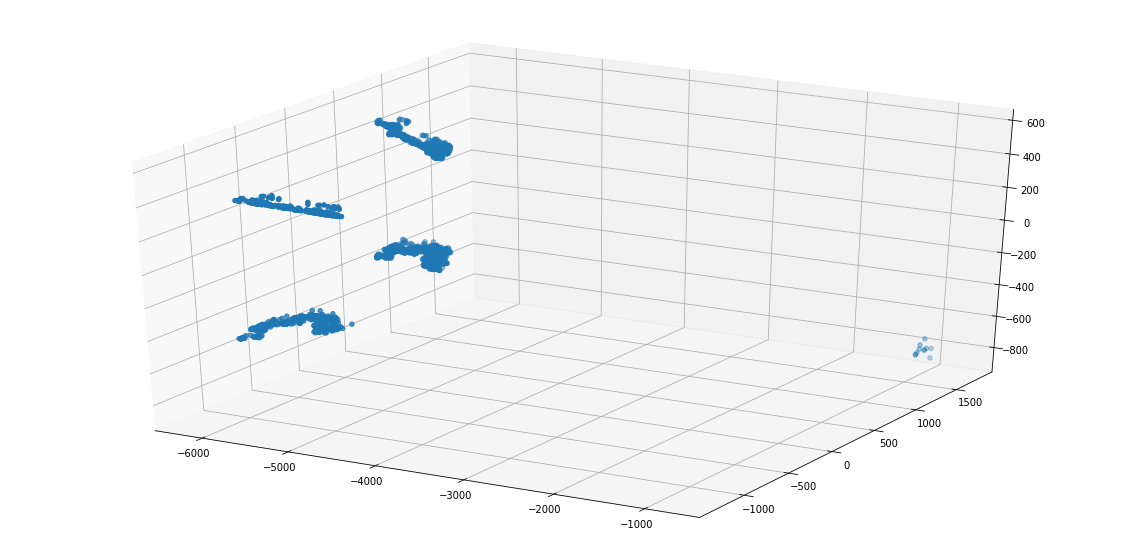

0.00070086186
2.340806e-06
0.10631094
iter 5	Distance-till-svd	0.10631094127893448	Total-variance-to-retain %	0.0033398964442312717	Total-variance-to-retain	2.3408060769725125e-06
epoch = 1, train error = 0.00010160
epoch = 1001, train error = 0.00010126
epoch = 2001, train error = 0.00010131
epoch = 3001, train error = 0.00010161
epoch = 4001, train error = 0.00010153
epoch = 5001, train error = 0.00010115
epoch = 6001, train error = 0.00010149
epoch = 7001, train error = 0.00010067
epoch = 8001, train error = 0.00010104
epoch = 9001, train error = 0.00010129
epoch = 10001, train error = 0.00010133
epoch = 11001, train error = 0.00010144
epoch = 12001, train error = 0.00010084
epoch = 13001, train error = 0.00010132
[6.04919333e-04 9.90741137e-06 2.62764161e-06 6.76592094e-07
 3.43824155e-07 2.14322938e-07 1.90512068e-07 1.64360841e-07
 1.28156771e-07 9.63166897e-08 8.52579802e-08 7.38435801e-08
 6.69631675e-08 4.18958592e-08 2.69093743e-08 2.57525130e-08
 1.69858723e-08 1.55097748e-0

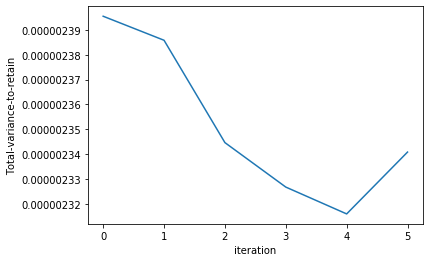

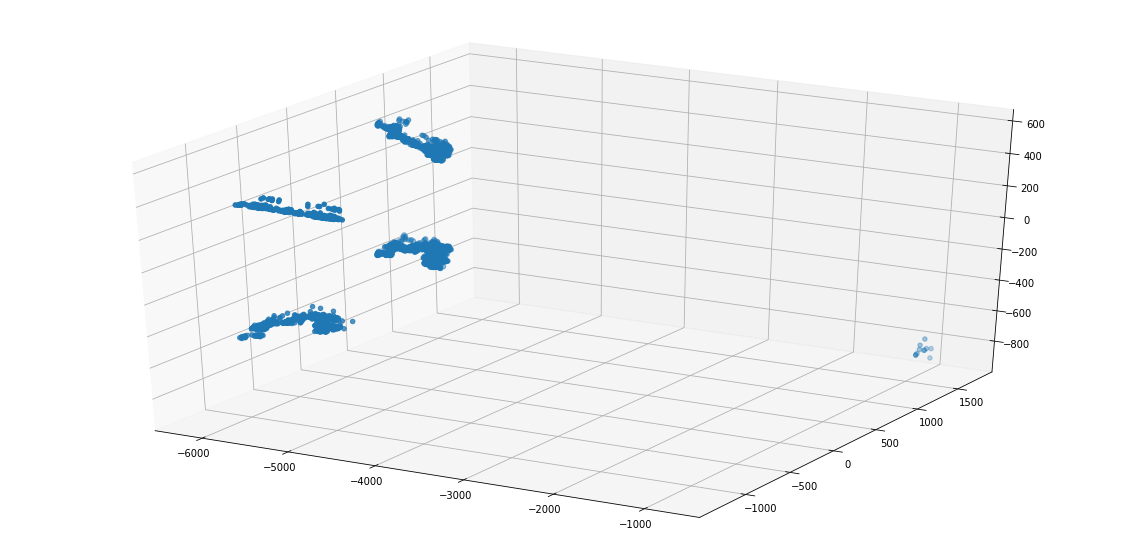

0.0006197998
2.3454313e-06
0.14148588
iter 6	Distance-till-svd	0.14148588478565216	Total-variance-to-retain %	0.003784175729379058	Total-variance-to-retain	2.3454313122783788e-06
epoch = 1, train error = 0.00010165
epoch = 1001, train error = 0.00010123
epoch = 2001, train error = 0.00010046
epoch = 3001, train error = 0.00010077
epoch = 4001, train error = 0.00010160
epoch = 5001, train error = 0.00010189
epoch = 6001, train error = 0.00010118
epoch = 7001, train error = 0.00010164
epoch = 8001, train error = 0.00010166
epoch = 9001, train error = 0.00010140
epoch = 10001, train error = 0.00010128
epoch = 11001, train error = 0.00010195
epoch = 12001, train error = 0.00010117
epoch = 13001, train error = 0.00010141
[6.50314381e-04 9.63735602e-06 2.38090843e-06 6.65384903e-07
 3.67608266e-07 2.31518840e-07 1.75370317e-07 1.62934242e-07
 1.13269500e-07 9.69741834e-08 8.65788863e-08 7.44648929e-08
 6.56367192e-08 4.29853131e-08 2.74795351e-08 2.38351596e-08
 1.89288709e-08 1.63156191e-08

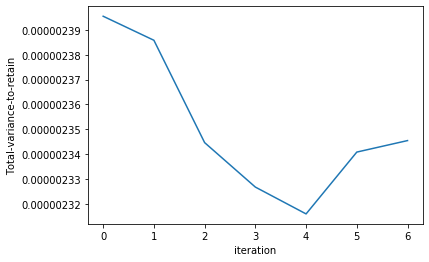

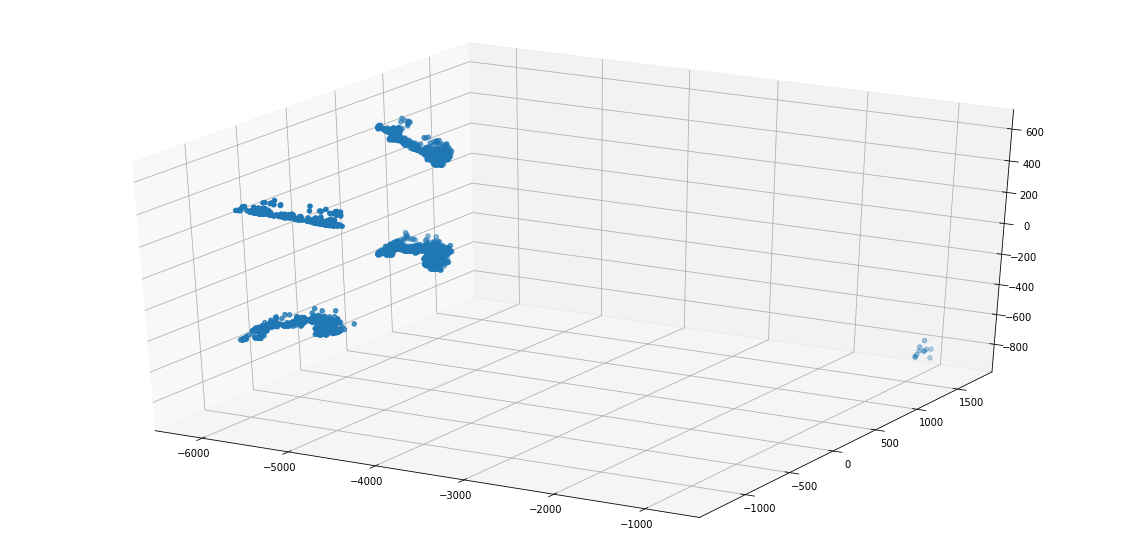

0.0006646805
2.347893e-06
0.14359252
iter 7	Distance-till-svd	0.14359252154827118	Total-variance-to-retain %	0.003532363334670663	Total-variance-to-retain	2.3478930870624026e-06
epoch = 1, train error = 0.00010105
epoch = 1001, train error = 0.00010138
epoch = 2001, train error = 0.00010096
epoch = 3001, train error = 0.00010177
epoch = 4001, train error = 0.00010116
epoch = 5001, train error = 0.00010094
epoch = 6001, train error = 0.00010192
epoch = 7001, train error = 0.00010094
epoch = 8001, train error = 0.00010191
epoch = 9001, train error = 0.00010074
epoch = 10001, train error = 0.00010097
epoch = 11001, train error = 0.00010083
epoch = 12001, train error = 0.00010070
epoch = 13001, train error = 0.00010151
epoch = 14001, train error = 0.00010114
epoch = 15001, train error = 0.00010108
epoch = 16001, train error = 0.00010081
epoch = 17001, train error = 0.00010023
epoch = 18001, train error = 0.00010164
epoch = 19001, train error = 0.00010091
epoch = 20001, train error = 0.0001

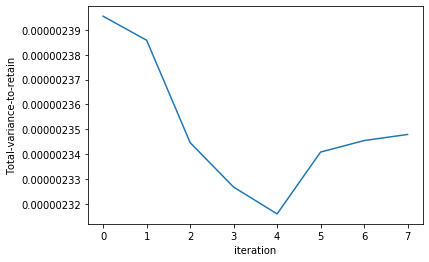

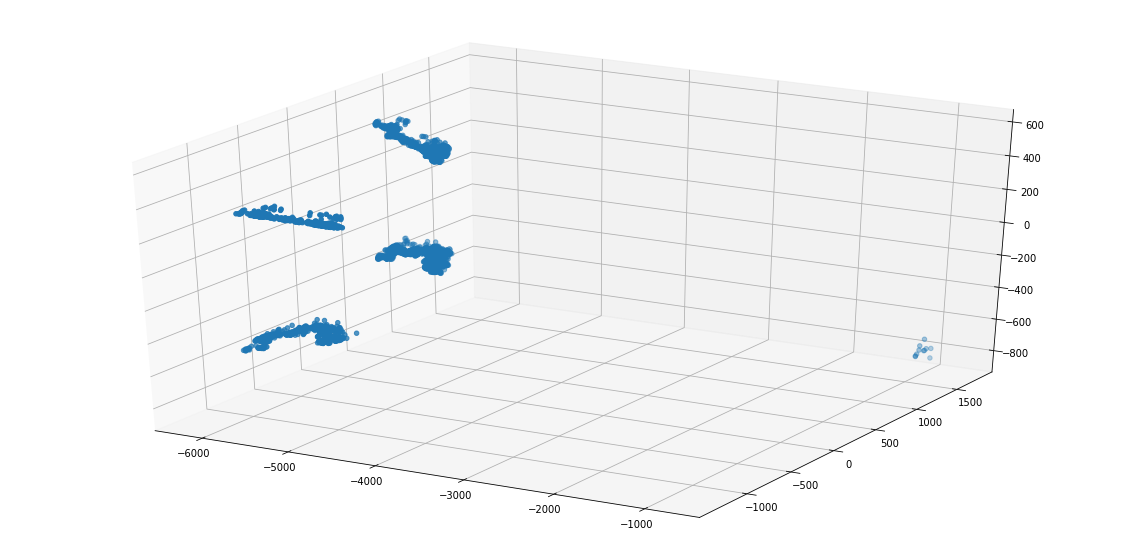

0.0006881252
2.3120465e-06
0.12203666
iter 8	Distance-till-svd	0.1220366582274437	Total-variance-to-retain %	0.0033599212765693665	Total-variance-to-retain	2.3120464902604e-06
epoch = 1, train error = 0.00010140
epoch = 1001, train error = 0.00010095
epoch = 2001, train error = 0.00010084
epoch = 3001, train error = 0.00010173
epoch = 4001, train error = 0.00010186
epoch = 5001, train error = 0.00010062
epoch = 6001, train error = 0.00010088
epoch = 7001, train error = 0.00010135
epoch = 8001, train error = 0.00010161
epoch = 9001, train error = 0.00010104
epoch = 10001, train error = 0.00010101
epoch = 11001, train error = 0.00010092
epoch = 12001, train error = 0.00010176
epoch = 13001, train error = 0.00010105
epoch = 14001, train error = 0.00010104
epoch = 15001, train error = 0.00010134
epoch = 16001, train error = 0.00010138
[6.51261071e-04 9.01586645e-06 2.47851381e-06 5.95937252e-07
 3.56729259e-07 2.07048501e-07 1.85294525e-07 1.65406121e-07
 1.14679864e-07 1.07802030e-07 8.76

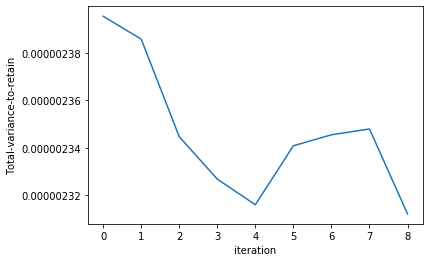

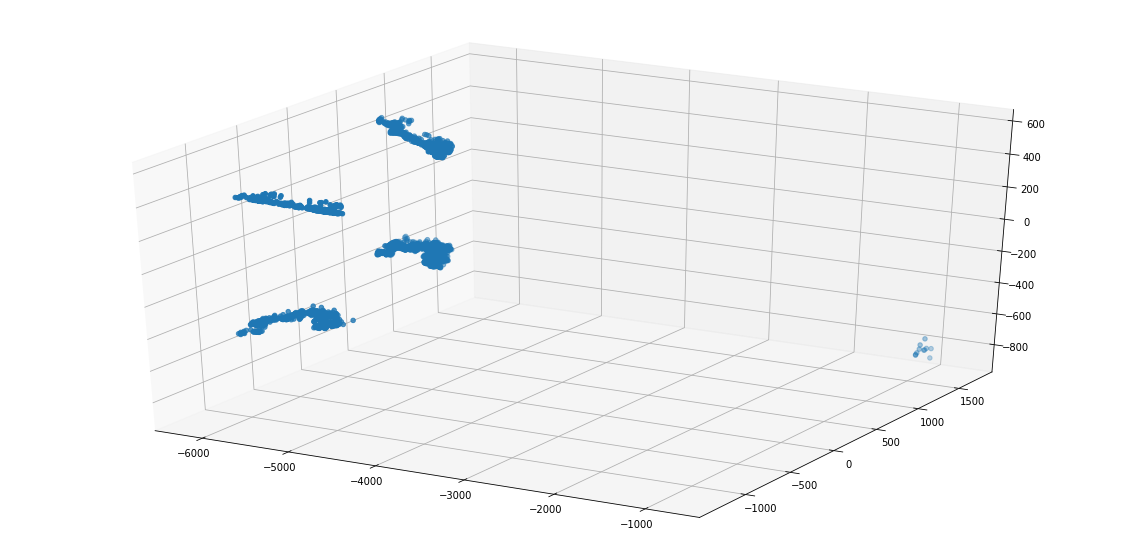

0.0006650112
2.2557192e-06
0.09351944
iter 9	Distance-till-svd	0.09351944178342819	Total-variance-to-retain %	0.003392001846805215	Total-variance-to-retain	2.255719209642848e-06
epoch = 1, train error = 0.00010147
epoch = 1001, train error = 0.00010160
epoch = 2001, train error = 0.00010104


In [ ]:
cur_w = np.random.normal(0, 0.35, (number_of_neurons,1))
cur_B =  np.random.normal(0, 0.35, (dimensionality, number_of_neurons))
cur_P = np.zeros((dimensionality, dimensionality))

lr = 0.0001
prev_run_res = 1000000000

# default session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for s in range(0, Num_iter):

    lr = 0.001
    epoch = 0
    while lr > 0.0000001:  # iterations epoch < 500000 and 
        
        sess.run(target, feed_dict={new_lr: lr, Dataplace: Data, Lbd: Lambda,
            tf_data_w: cur_w,
            tf_data_B: cur_B,
            tf_data_P: cur_P
        })

        if epoch % 1000 == 0:
            run_res = 0.0
            for times in range(100):
                run_res = run_res + sess.run(loss, feed_dict={Dataplace: Data, Lbd: Lambda,
                                               tf_data_w: cur_w,
                                               tf_data_B: cur_B,
                                               tf_data_P: cur_P})
            run_res = run_res/100.0
            print("epoch = %d, train error = %.8f" % (epoch + 1, run_res))

            if  run_res > prev_run_res:
                lr *= lr_decay
            prev_run_res = run_res

        epoch += 1
        
    cur_w, cur_B = sess.run([w, B])    

    third_grad_psi = np.reshape(sess.run([grad_psi]), (BATCH_SIZE_2, dimensionality))
    for r in range(1000):
        sess.run([tf_data_second])
        np.concatenate((third_grad_psi, np.reshape(sess.run([grad_psi]), (BATCH_SIZE_2, dimensionality))), axis=0) 

    u, s, vh = np.linalg.svd(np.matmul(np.transpose(third_grad_psi), third_grad_psi), full_matrices=True)
    O = u[:,0:k:1]
    print(s)
#    print(u)
#    print(O)
    cur_P = np.matmul(O, np.transpose(O))
#    print(cur_P)

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    Data2 = np.matmul(images, O)
    ax.scatter(Data2[:,0], Data2[:,1], Data2[:,2])
    plt.show()

    print(np.sum(np.square(third_grad_psi)))
    print(np.sum(np.square(third_grad_psi-np.matmul(third_grad_psi, cur_P))))
    print(np.sqrt(np.sum(np.square(P_svd-cur_P))))
    lib.plot.plot('Distance-till-svd', np.sqrt(np.sum(np.square(P_svd-cur_P))))
    lib.plot.plot('Total-variance-to-retain %', np.sum(np.square(third_grad_psi-np.matmul(third_grad_psi, cur_P)))/np.sum(np.square(third_grad_psi)))
    lib.plot.plot('Total-variance-to-retain', np.sum(np.square(third_grad_psi-np.matmul(third_grad_psi, cur_P))))
    lib.plot.flush()
    lib.plot.tick()

sess.close()
print(cur_P)